In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import seaborn as sns; sns.set()
from scipy.spatial.distance import pdist, squareform
import glob
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
training_files = sorted(glob.glob(r'F:\Geology\WSGS\Projects\jupyter\*.csv'))

In [4]:
truncation_color = '#ffffbf'
onlap_color = '#2c7bb6'
horiz_color = '#d7191c'

from matplotlib.colors import LinearSegmentedColormap

truncCmap = LinearSegmentedColormap.from_list('mycmap', [truncation_color, onlap_color])
onlapCmap = LinearSegmentedColormap.from_list('mycmap', [truncation_color, onlap_color])
horizCmap = LinearSegmentedColormap.from_list('mycmap', [onlap_color, horiz_color])



tops_api = pd.read_csv(r"F:\Geology\WSGS\Projects\jupyter\EarlyWSGS\ftunion.csv").fillna(
    0
)  # this file is available in the unconformity or onlap folder in the repo
iterable = ["Kfh",  "Kl", "Tfu"]
topcombos = list(zip(iterable, iterable[1:]))

In [5]:
from sklearn.model_selection import train_test_split
from tqdm import tqdm

accuracy_measured = []
ft_classes = []
lance_classes = []
header = []

for file in training_files:
    print(f'reading {file[-15:]}')
    no_of_neighbors = int(file[33:-13])
    data = pd.read_csv(file, index_col=[0])
    data_subset0 = data.drop(['class'], axis=1)

    dataset = data

    # next let's split our toy data into training and test sets, choose how much with test_size of the data becomes the test set
    X_train, X_test, y_train, y_test = train_test_split(
        dataset.drop('class', axis=1),
        dataset['class'],
        test_size=0.1, #don't forget to change this
        random_state=86,
    )
    from sklearn.neighbors import KNeighborsClassifier
    neigh = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
               metric_params=None, n_jobs=None, n_neighbors=4, p=2,
               weights='distance')
    neigh.fit(X_train, y_train)
    accuracy_measured.append(neigh.score(X_test, y_test))
    


    # run this for all combinations of 2 tops and KNN
    results = []
    norm_all = []
    probs_all = []
    full_probs = []

    for j in enumerate(topcombos):
        print(topcombos[j[0]])
        tops_api = pd.read_csv(r"F:\Geology\WSGS\Projects\jupyter\EarlyWSGS\ftunion.csv").fillna(
            0
        )  # this file is available in the unconformity or onlap folder in the repo
        fmtops = list(topcombos[j[0]])
        fmtops.extend(["x", "y"])
        tops = tops_api[fmtops]

        # calculate thicknesses and neighbors for the two tops
        hood = squareform(pdist(tops.iloc[:, -2:]))
        neighbors = []
        for i in enumerate(hood.argsort()[0:, 1 : no_of_neighbors + 1]):
            selected = (
                tops.iloc[hood.argsort()[i[0], 1 : no_of_neighbors + 1], 0:-2]
                .stack()
                .to_frame()
                .T
            )
            selected.columns = selected.columns.droplevel()
            neighbors.append(selected)
        frame = pd.concat(neighbors, sort=False)
        frame.index = range(len(frame))
        neighborhood = pd.concat([tops.iloc[:, :-2], frame], axis=1)
        thicknesses = neighborhood.diff(axis=1) * -1
        thicknesses[thicknesses < 0] = 0
        thicknesses.drop(columns=tops.columns[0], inplace=True)
        thicknesses[thicknesses < 0] = 0
        thicknesses[thicknesses > 3000] = 0
        locations = tops[["x", "y"]]
        real_world_log = thicknesses.apply(
            np.log
        )  # take the log of thicknesses for feature engineering
        real_world_pow = thicknesses.apply(
            lambda x: x ** 10
        )  # calculates the power values of thickness for another feature
        rw = (
            pd.concat(
                [thicknesses, real_world_log, real_world_pow, locations],
                axis=1,
                join_axes=[thicknesses.index],
            )
            .dropna()
            .replace(-np.inf, 0)
        )
        normalized_rw = (rw - rw.min()) / (rw.max() - rw.min()).replace(
            0, 0.00001
        )  # normalize the data from 0 to 1
        real_data = normalized_rw.values

        well_preds = neigh.predict(real_data) #knn predictions
        well_prob = neigh.predict_proba(real_data) #knn predictions
        full_probs.append(well_prob)
        probs = []
        for i in range(len(well_prob)):
            probs.append(well_prob[i].max())
        probs_all.append(probs)
        results.append(well_preds)
        norm_all.append(normalized_rw)

    normalized_kl = norm_all[0]
    normalized_tfu = norm_all[1]

    normalized_kl.columns = data_subset0.columns.values
    normalized_kl['class'] = results[0]
    normalized_kl['prob'] = probs_all[0]

    normalized_tfu.columns = data_subset0.columns.values
    normalized_tfu['class'] = results[1]
    normalized_tfu['prob'] = probs_all[1]

    #df_subset = data#.sample(80000, random_state=20)
    #df_subset['model'] = 'geometric' #this is geometric
    normalized_kl['Formation'] = 'Kl' # this is lance
    normalized_tfu['Formation'] = 'Tfu' # this is ft union

    #df_combined = df_subset.append(normalized_kl, sort=False)
    df_combined = normalized_kl
    df_combined1 = df_combined.append(normalized_tfu, sort=False)
    x_locs = tops_api.x.append(tops_api.x,  ignore_index=True)
    y_locs = tops_api.y.append(tops_api.y,  ignore_index=True)
    api = tops_api.API.append(tops_api.API,  ignore_index=True)

    df_combined1['x_locs'] =x_locs
    df_combined1['y_locs'] = y_locs
    df_combined1['api'] = api

    probabilities = np.vstack(full_probs)
    df_combined1['trunc_prob'] = probabilities[:,0]
    df_combined1['onlap_prob'] = probabilities[:,1]
    df_combined1['horiz_prob'] = probabilities[:,2]

    ftunion = df_combined1[df_combined1['Formation']=='Tfu']
    lancer = df_combined1[df_combined1['Formation']=='Kl']
    '''
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    forts = [ftunion.trunc_prob, ftunion.onlap_prob, ftunion.horiz_prob]
    plt.hist(forts, stacked=True, color=[truncation_color, onlap_color, horiz_color])
    plt.xlim(0.1,1.1)
    plt.ylim(0,900)
    plt.title('fort union prob with '+str(no_of_neighbors)+' neighbors')

    plt.subplot(122)
    lan = [lancer.trunc_prob, lancer.onlap_prob, lancer.horiz_prob]
    plt.hist(lan, stacked=True, color=[truncation_color, onlap_color, horiz_color])
    plt.xlim(0.1,1.1)
    plt.ylim(0,900)
    plt.title('lance prob with '+str(no_of_neighbors)+' neighbors')
    plt.savefig('probabilities_with_'+str(no_of_neighbors)+'_neighbors.jpg')
    
    

    fthoriz = ftunion[(ftunion.horiz_prob>0.)]

    plt.figure(figsize=(30,10))
    plt.subplot(121)
    plt.scatter(ftunion['x_locs'], ftunion['y_locs'], alpha=0.1, c='k')
    plt.scatter(ftunion['x_locs'], ftunion['y_locs'], c=ftunion['trunc_prob']*-1, cmap=truncCmap, vmin=-1, vmax=0)
    plt.scatter(ftunion['x_locs'], ftunion['y_locs'], c=ftunion['onlap_prob'], cmap=onlapCmap, vmin=0, vmax=1)
    plt.scatter(fthoriz['x_locs'], fthoriz['y_locs'], c=fthoriz['horiz_prob'], cmap=horizCmap, vmin=0, vmax=1)
    plt.title('fort union '+str(no_of_neighbors))

    lahoriz = lancer[(lancer.horiz_prob>0.)]

    plt.subplot(122)
    plt.scatter(lancer['x_locs'], lancer['y_locs'], c=lancer['trunc_prob']*-1, cmap=truncCmap, vmin=-1, vmax=0)
    plt.scatter(lancer['x_locs'], lancer['y_locs'], c=lancer['onlap_prob'], cmap=onlapCmap, vmin=0, vmax=1)
    plt.scatter(lahoriz['x_locs'], lahoriz['y_locs'], c=lahoriz['horiz_prob'], cmap=horizCmap, vmin=0, vmax=1)
    plt.title('lance '+str(no_of_neighbors))
    
    plt.savefig('spatial map with '+str(no_of_neighbors))
    '''
    ft_classes.append(ftunion['class'])
    lance_classes.append(lancer['class'])
    header.append(str(no_of_neighbors)+'neighbors')
ftDF = pd.DataFrame(ft_classes).T
laDF = pd.DataFrame(lance_classes).T
#plt.plot(abs(laDF.diff(axis=1)).sum().values)

reading 00neighbors.csv
('Kfh', 'Kl')
('Kl', 'Tfu')
reading 01neighbors.csv
('Kfh', 'Kl')
('Kl', 'Tfu')
reading 02neighbors.csv
('Kfh', 'Kl')
('Kl', 'Tfu')
reading 03neighbors.csv
('Kfh', 'Kl')
('Kl', 'Tfu')
reading 04neighbors.csv
('Kfh', 'Kl')
('Kl', 'Tfu')
reading 05neighbors.csv
('Kfh', 'Kl')
('Kl', 'Tfu')
reading 06neighbors.csv
('Kfh', 'Kl')
('Kl', 'Tfu')
reading 07neighbors.csv
('Kfh', 'Kl')
('Kl', 'Tfu')
reading 08neighbors.csv
('Kfh', 'Kl')
('Kl', 'Tfu')
reading 09neighbors.csv
('Kfh', 'Kl')
('Kl', 'Tfu')
reading 10neighbors.csv
('Kfh', 'Kl')
('Kl', 'Tfu')
reading 11neighbors.csv
('Kfh', 'Kl')
('Kl', 'Tfu')
reading 12neighbors.csv
('Kfh', 'Kl')
('Kl', 'Tfu')
reading 13neighbors.csv
('Kfh', 'Kl')
('Kl', 'Tfu')
reading 14neighbors.csv
('Kfh', 'Kl')
('Kl', 'Tfu')
reading 15neighbors.csv
('Kfh', 'Kl')
('Kl', 'Tfu')
reading 16neighbors.csv
('Kfh', 'Kl')
('Kl', 'Tfu')
reading 17neighbors.csv
('Kfh', 'Kl')
('Kl', 'Tfu')
reading 18neighbors.csv
('Kfh', 'Kl')
('Kl', 'Tfu')
reading 19ne

In [6]:
ftDF = pd.DataFrame(ft_classes).T
laDF = pd.DataFrame(lance_classes).T

In [11]:
laDF.diff(axis=1).astype(bool).sum(axis=0).values[1:]#
ftDF.diff(axis=1).astype(bool).sum(axis=0).values[1:]

array([145, 118,  88,  45,  52,  52,  46,  50,  38,  45,  41,  30,  30,
        30,  23,  31,  22,  17,  21,  28,  77,  40,  61,  25,  14,  11,
        17,  18, 182, 194], dtype=int64)

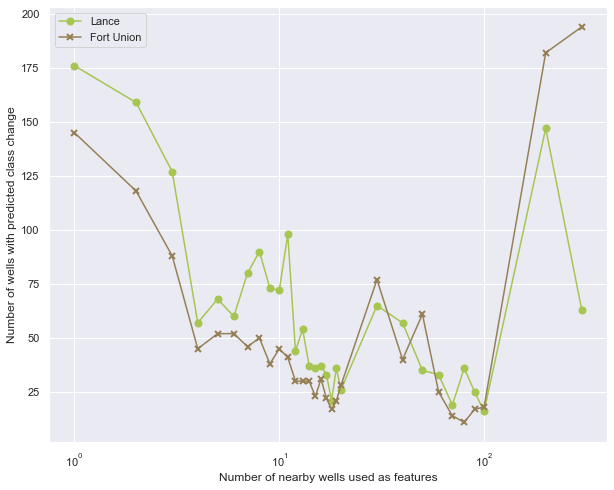

In [7]:
ex = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,30,40,50,60,70,80,90,100,200,300]
plt.figure(figsize=(10,8))
plt.plot(ex, laDF.diff(axis=1).astype(bool).sum(axis=0).values[1:], marker='o', color='#A6C551', label='Lance', mew=2)
plt.plot(ex, ftDF.diff(axis=1).astype(bool).sum(axis=0).values[1:], marker='x', color='#957F56', label='Fort Union', mew=2)
plt.legend()
plt.semilogx()
plt.ylabel('Number of wells with predicted class change')
plt.xlabel('Number of nearby wells used as features')
plt.savefig('optimized.pdf')

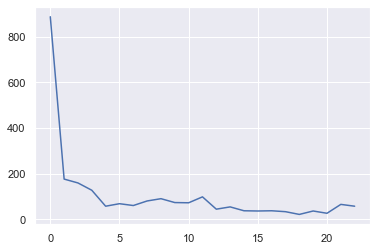

In [18]:
plt.plot(laDF.diff(axis=1).astype(bool).sum(axis=0).values)

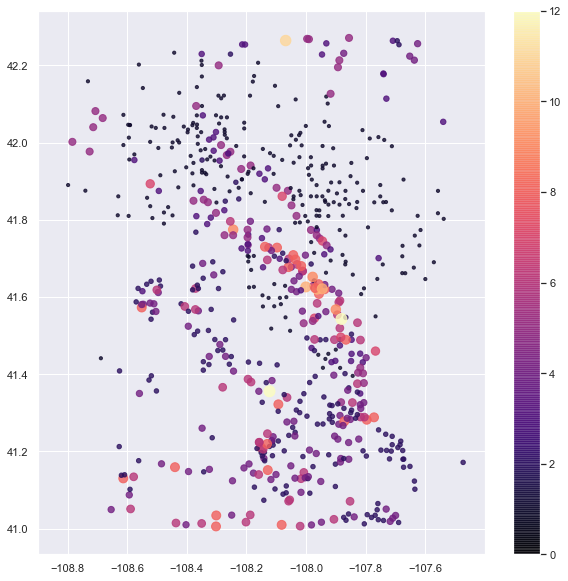

In [47]:
plt.figure(figsize=(10,10))
plt.scatter(lancer['x_locs'], lancer['y_locs'], alpha=0.8, c=abs(laDF.diff(axis=1)).sum(axis=1),s=abs(laDF.diff(axis=1)).sum(axis=1)*10, cmap='magma')
plt.colorbar()

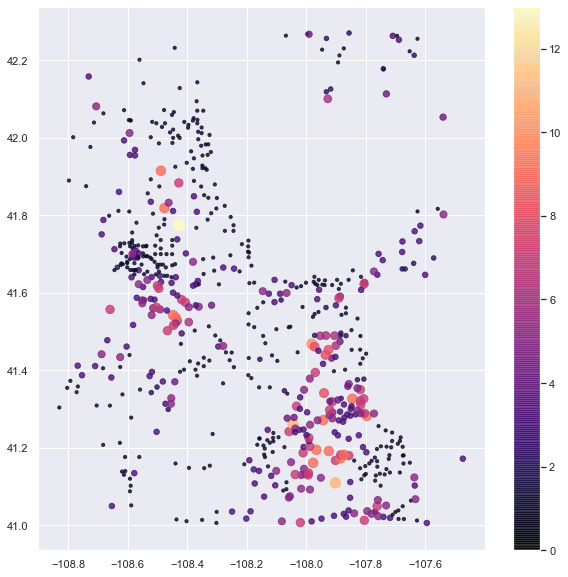

In [48]:
plt.figure(figsize=(10,10))
plt.scatter(ftunion['x_locs'], ftunion['y_locs'], alpha=0.8, c=abs(ftDF.diff(axis=1)).sum(axis=1), s=abs(ftDF.diff(axis=1)).sum(axis=1)*10, cmap='magma')
plt.colorbar()

In [ ]:
fthoriz = ftunion[(ftunion.horiz_prob>0.)]

plt.figure(figsize=(30,10))
plt.subplot(121)
plt.scatter(ftunion['x_locs'], ftunion['y_locs'], alpha=0.1, c=)
plt.scatter(ftunion['x_locs'], ftunion['y_locs'], c=ftunion['trunc_prob']*-1, cmap=truncCmap, vmin=-1, vmax=0)
plt.scatter(ftunion['x_locs'], ftunion['y_locs'], c=ftunion['onlap_prob'], cmap=onlapCmap, vmin=0, vmax=1)
plt.scatter(fthoriz['x_locs'], fthoriz['y_locs'], c=fthoriz['horiz_prob'], cmap=horizCmap, vmin=0, vmax=1)
plt.title('fort union '+str(no_of_neighbors))

lahoriz = lancer[(lancer.horiz_prob>0.)]

plt.subplot(122)
plt.scatter(lancer['x_locs'], lancer['y_locs'], c=lancer['trunc_prob']*-1, cmap=truncCmap, vmin=-1, vmax=0)
plt.scatter(lancer['x_locs'], lancer['y_locs'], c=lancer['onlap_prob'], cmap=onlapCmap, vmin=0, vmax=1)
plt.scatter(lahoriz['x_locs'], lahoriz['y_locs'], c=lahoriz['horiz_prob'], cmap=horizCmap, vmin=0, vmax=1)
plt.title('lance '+str(no_of_neighbors))

Text(0.5, 1.0, 'lance 4')

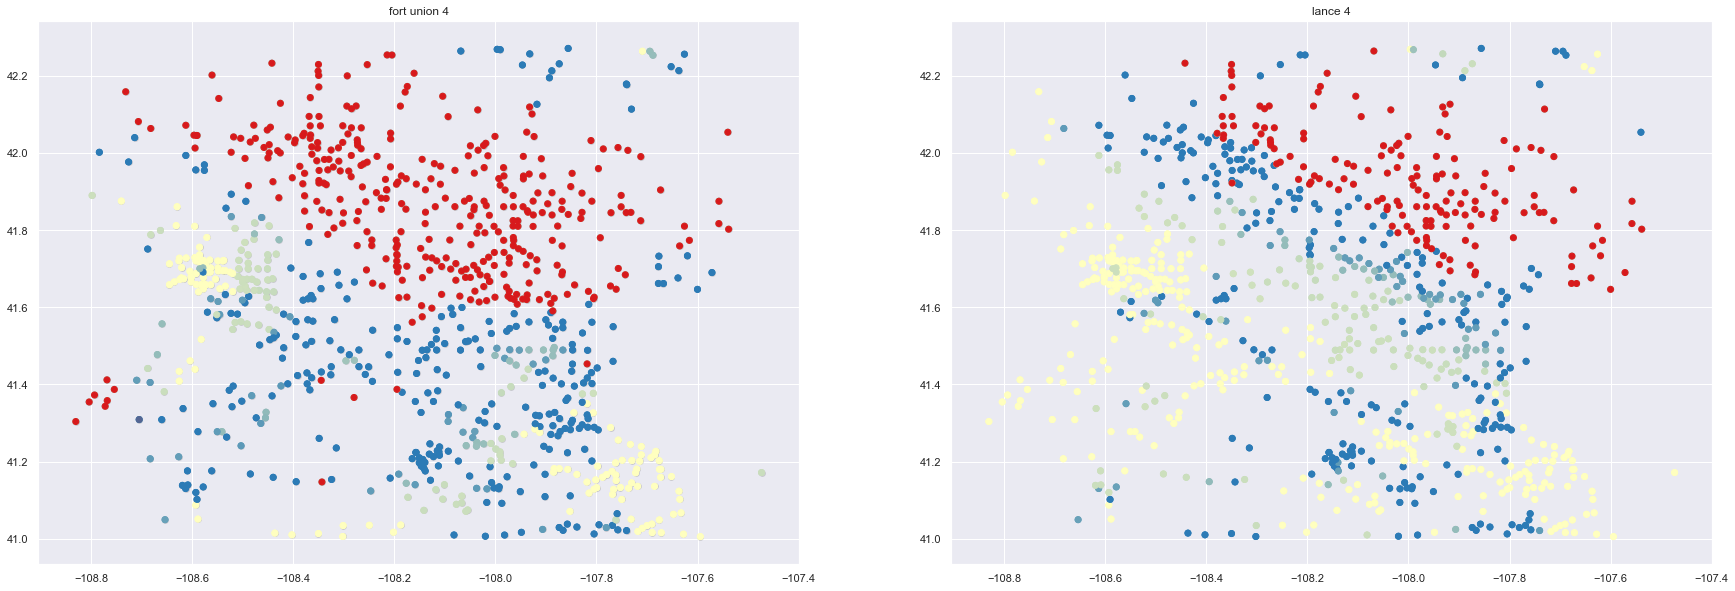

In [8]:
plt.figure(figsize=(30,10))
plt.subplot(121)
plt.scatter(ftunion['x_locs'], ftunion['y_locs'], alpha=0.1, c='k')
plt.scatter(ftunion['x_locs'], ftunion['y_locs'], c=ftunion['trunc_prob']*-1, cmap=truncCmap, vmin=-1, vmax=0)
plt.scatter(ftunion['x_locs'], ftunion['y_locs'], c=ftunion['onlap_prob'], cmap=onlapCmap, vmin=0, vmax=1)
plt.scatter(fthoriz['x_locs'], fthoriz['y_locs'], c=fthoriz['horiz_prob'], cmap=horizCmap, vmin=0, vmax=1)
plt.title('fort union '+str(no_of_neighbors))

lahoriz = lancer[(lancer.horiz_prob>0.)]

plt.subplot(122)
plt.scatter(lancer['x_locs'], lancer['y_locs'], c=lancer['trunc_prob']*-1, cmap=truncCmap, vmin=-1, vmax=0)
plt.scatter(lancer['x_locs'], lancer['y_locs'], c=lancer['onlap_prob'], cmap=onlapCmap, vmin=0, vmax=1)
plt.scatter(lahoriz['x_locs'], lahoriz['y_locs'], c=lahoriz['horiz_prob'], cmap=horizCmap, vmin=0, vmax=1)
plt.title('lance '+str(no_of_neighbors))

In [ ]:
accuracy_measured

('Kfh', 'Kl')


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\machinelearning\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.


('Kl', 'Tfu')


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\machinelearning\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.


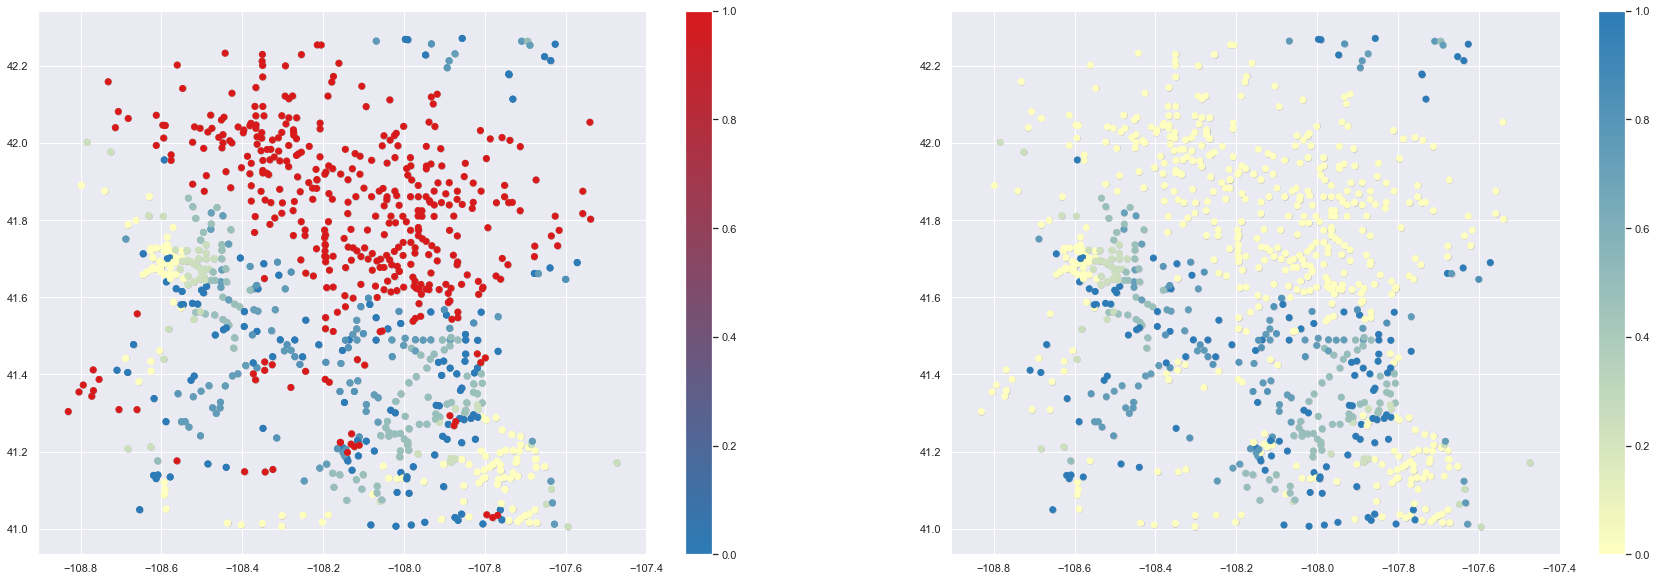

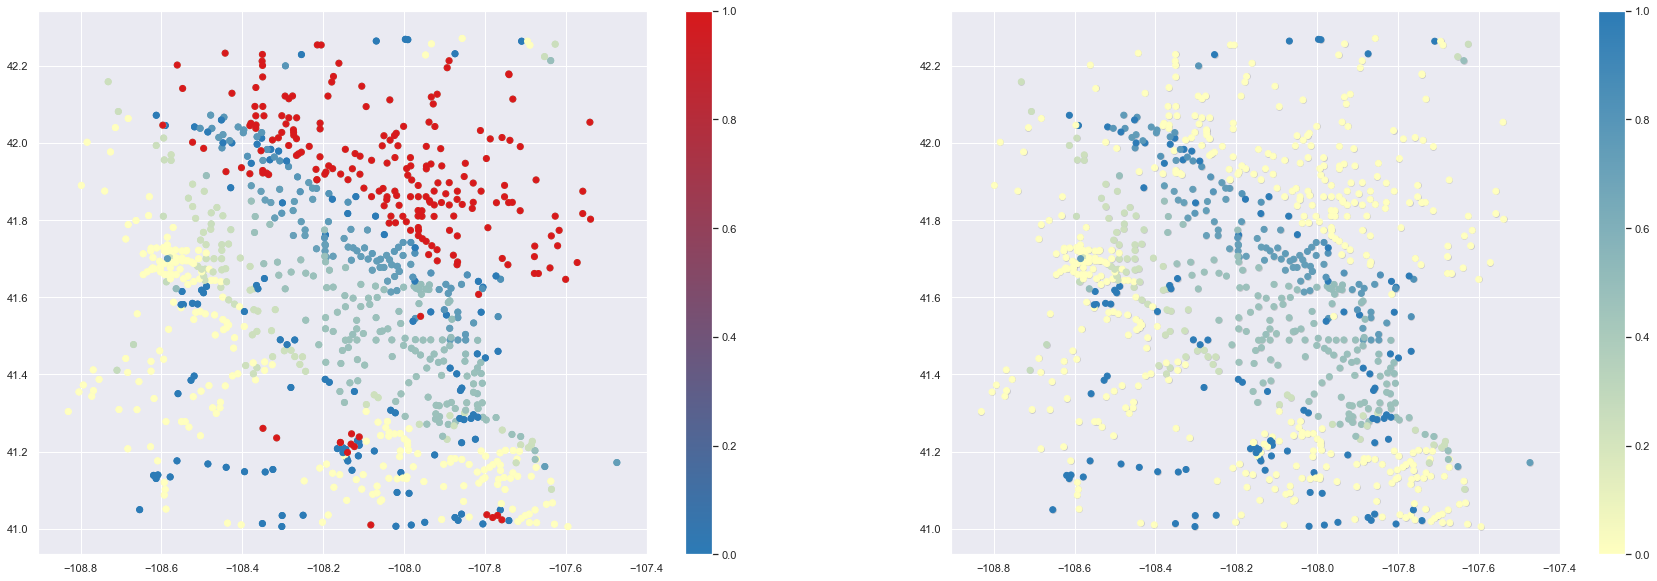

In [19]:


# run this for all combinations of 2 tops and KNN
results = []
norm_all = []
probs_all = []
full_probs = []

for j in enumerate(topcombos):
    print(topcombos[j[0]])
    tops_api = pd.read_csv(r"F:\Geology\WSGS\Projects\jupyter\EarlyWSGS\ftunion.csv").fillna(
        0
    )  # this file is available in the unconformity or onlap folder in the repo
    fmtops = list(topcombos[j[0]])
    fmtops.extend(["x", "y"])
    tops = tops_api[fmtops]

    # calculate thicknesses and neighbors for the two tops
    hood = squareform(pdist(tops.iloc[:, -2:]))
    neighbors = []
    for i in enumerate(hood.argsort()[0:, 1 : no_of_neighbors + 1]):
        selected = (
            tops.iloc[hood.argsort()[i[0], 1 : no_of_neighbors + 1], 0:-2]
            .stack()
            .to_frame()
            .T
        )
        selected.columns = selected.columns.droplevel()
        neighbors.append(selected)
    frame = pd.concat(neighbors, sort=False)
    frame.index = range(len(frame))
    neighborhood = pd.concat([tops.iloc[:, :-2], frame], axis=1)
    thicknesses = neighborhood.diff(axis=1) * -1
    thicknesses[thicknesses < 0] = 0
    thicknesses.drop(columns=tops.columns[0], inplace=True)
    thicknesses[thicknesses < 0] = 0
    thicknesses[thicknesses > 3000] = 0
    locations = tops[["x", "y"]]
    real_world_log = thicknesses.apply(
        np.log
    )  # take the log of thicknesses for feature engineering
    real_world_pow = thicknesses.apply(
        lambda x: x ** 10
    )  # calculates the power values of thickness for another feature
    rw = (
        pd.concat(
            [thicknesses, real_world_log, real_world_pow, locations],
            axis=1,
            join_axes=[thicknesses.index],
        )
        .dropna()
        .replace(-np.inf, 0)
    )
    normalized_rw = (rw - rw.min()) / (rw.max() - rw.min()).replace(
        0, 0.00001
    )  # normalize the data from 0 to 1
    real_data = normalized_rw.values

    well_preds = neigh.predict(real_data) #knn predictions
    well_prob = neigh.predict_proba(real_data) #knn predictions
    full_probs.append(well_prob)
    probs = []
    for i in range(len(well_prob)):
        probs.append(well_prob[i].max())
    probs_all.append(probs)
    results.append(well_preds)
    norm_all.append(normalized_rw)
    
normalized_kl = norm_all[0]
normalized_tfu = norm_all[1]

normalized_kl.columns = data_subset0.columns.values
normalized_kl['class'] = results[0]
normalized_kl['prob'] = probs_all[0]

normalized_tfu.columns = data_subset0.columns.values
normalized_tfu['class'] = results[1]
normalized_tfu['prob'] = probs_all[1]

#df_subset = data#.sample(80000, random_state=20)
#df_subset['model'] = 'geometric' #this is geometric
normalized_kl['Formation'] = 'Kl' # this is lance
normalized_tfu['Formation'] = 'Tfu' # this is ft union

#df_combined = df_subset.append(normalized_kl, sort=False)
df_combined = normalized_kl
df_combined1 = df_combined.append(normalized_tfu, sort=False)
x_locs = tops_api.x.append(tops_api.x,  ignore_index=True)
y_locs = tops_api.y.append(tops_api.y,  ignore_index=True)
api = tops_api.API.append(tops_api.API,  ignore_index=True)

df_combined1['x_locs'] =x_locs
df_combined1['y_locs'] = y_locs
df_combined1['api'] = api


df_combined1['trunc_prob'] = probabilities[:,0]
df_combined1['onlap_prob'] = probabilities[:,1]
df_combined1['horiz_prob'] = probabilities[:,2]

ftunion = df_combined1[df_combined1['Formation']=='Tfu']
lancer = df_combined1[df_combined1['Formation']=='Kl']
probabilities = np.vstack(full_probs)

plt.figure(figsize=(10,5))
plt.subplot(121)
forts = [ftunion.trunc_prob, ftunion.onlap_prob, ftunion.horiz_prob]
plt.hist(forts, stacked=True, color=[truncation_color, onlap_color, horiz_color])
plt.xlim(0.1,1.1)
plt.ylim(0,900)
plt.title('fort union prob with '+str(no_of_neighbors)+' neighbors')

plt.subplot(122)
lan = [lancer.trunc_prob, lancer.onlap_prob, lancer.horiz_prob]
plt.hist(lan, stacked=True, color=[truncation_color, onlap_color, horiz_color])
plt.xlim(0.1,1.1)
plt.ylim(0,900)
plt.title('lance prob with '+str(no_of_neighbors)+' neighbors')
plt.savefig('probabilities_with_'+str(no_of_neighbors)+'_neighbors.jpg')


fthoriz = ftunion[(ftunion.horiz_prob>0.)]

plt.figure(figsize=(30,10))
plt.subplot(121)
plt.scatter(ftunion['x_locs'], ftunion['y_locs'], alpha=0.1, c='k')
plt.scatter(ftunion['x_locs'], ftunion['y_locs'], c=ftunion['trunc_prob']*-1, cmap=truncCmap, vmin=-1, vmax=0)
plt.scatter(ftunion['x_locs'], ftunion['y_locs'], c=ftunion['onlap_prob'], cmap=onlapCmap, vmin=0, vmax=1)
plt.scatter(fthoriz['x_locs'], fthoriz['y_locs'], c=fthoriz['horiz_prob'], cmap=horizCmap, vmin=0, vmax=1)
plt.title('fort union '+str(no_of_neighbors))

lahoriz = lancer[(lancer.horiz_prob>0.)]

plt.figure(figsize=(30,10))
plt.subplot(122)
plt.scatter(lancer['x_locs'], lancer['y_locs'], c=lancer['trunc_prob']*-1, cmap=truncCmap, vmin=-1, vmax=0)
plt.scatter(lancer['x_locs'], lancer['y_locs'], c=lancer['onlap_prob'], cmap=onlapCmap, vmin=0, vmax=1)
plt.scatter(lahoriz['x_locs'], lahoriz['y_locs'], c=lahoriz['horiz_prob'], cmap=horizCmap, vmin=0, vmax=1)
plt.title('lance '+str(no_of_neighbors))

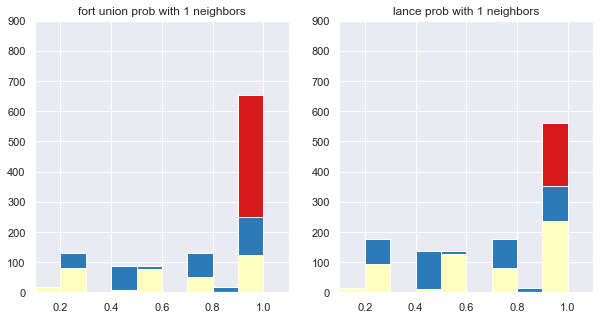

In [37]:
plt.figure(figsize=(10,5))
plt.subplot(121)
forts = [ftunion.trunc_prob, ftunion.onlap_prob, ftunion.horiz_prob]
plt.hist(forts, stacked=True, color=[truncation_color, onlap_color, horiz_color])
plt.xlim(0.1,1.1)
plt.ylim(0,900)
plt.title('fort union prob with '+str(no_of_neighbors)+' neighbors')

plt.subplot(122)
lan = [lancer.trunc_prob, lancer.onlap_prob, lancer.horiz_prob]
plt.hist(lan, stacked=True, color=[truncation_color, onlap_color, horiz_color])
plt.xlim(0.1,1.1)
plt.ylim(0,900)
plt.title('lance prob with '+str(no_of_neighbors)+' neighbors')
plt.savefig('probabilities_with_'+str(no_of_neighbors)+'_neighbors.jpg')

Text(0.5, 1.0, 'lance prob with 1 neighbors')

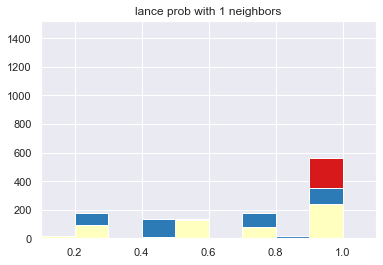

In [32]:
lan = [lancer.trunc_prob, lancer.onlap_prob, lancer.horiz_prob]
plt.hist(lan, stacked=True, color=[truncation_color, onlap_color, horiz_color])
plt.xlim(0.1,1.1)
plt.title('lance prob with '+str(no_of_neighbors)+' neighbors')